In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from class_pig import pigClass  

from pathlib import Path
import pickle

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fitterClass import funcFitter
from utils import exponential_cicle, find_best_b, plot_exponentials
from collections import namedtuple

In [3]:
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

def exponential_cicle_fixed_b(best_b, x, a, c):
    return -a*np.exp(-best_b*x)+c

estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

In [4]:
dataframes_lst = []
aux_test = {}
for file_name in Path('porquinhos').rglob('*.pickle'):
    
    if file_name.name == "porquinho_mra26.pickle": 
        print(file_name.name)
        
        with open(file_name, "rb") as file:

            porquinho = pickle.load(file)
            for manobra in porquinho: #Para cada manobra 

                if manobra == "D": # Posso fazer 3,4,5 passos
                    n_steps = 5
                elif manobra == "C": # Posso fazer 3,4 passos
                    n_steps = 4
                elif manobra == "B": # Posso fazer 3 passos
                    n_steps = 3

                # Formato os dados de entrada
                format_data = []

                for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                          porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                    format_data.extend([pi,wi,pe,we])

                format_data = np.array(format_data).reshape(-1,2)

                ##########################################################

                for n_point in range(3,n_steps+1):
                    if manobra == "D" and porquinho.name == "mra26":
                        aux_test[n_point] = format_data.copy()
                    fitter = funcFitter(porquinho.name, manobra, format_data, format_data[0::2, :], n_point = n_point, estimators = estimators)
                    dataframes_lst.append(fitter.fit(funcs=funcs, interpolate=True, n_interp_point=20, interp_method="linear"))

porquinho_mra26.pickle


In [5]:
df = pd.concat(dataframes_lst,ignore_index=True)

In [7]:
df_test = df.query("manobra == 'D'")\
            .sort_values(by = "error")\
            .reset_index(drop=True)\
            .loc[:4]\
            .copy()

In [8]:
df_test[["best_b", "guess_zero"]] = df_test.apply(find_best_b, axis=1, result_type="expand")

In [9]:
df_test.iloc[0]

subject                                                        mra26
manobra                                                            D
n_point                                                            5
function                    <function sigmoid at 0x000002845308E3A8>
function_name                                                sigmoid
estimator                                                         lm
error                                                       0.227276
param              [-296.6860380729812, 1708.2337167840847, 28.17...
interp_point                                                       5
interp_pressure    [10.178125381469727, 15.249219179153442, 20.32...
interp_volume      [-197.8517303466797, -93.77818494931996, 93.38...
raw_data           [[10.178125381469727, -197.8517303466797], [20...
best_b                                                         0.057
guess_zero                   [10.05812538146973, -199.4321542176138]
Name: 0, dtype: object

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


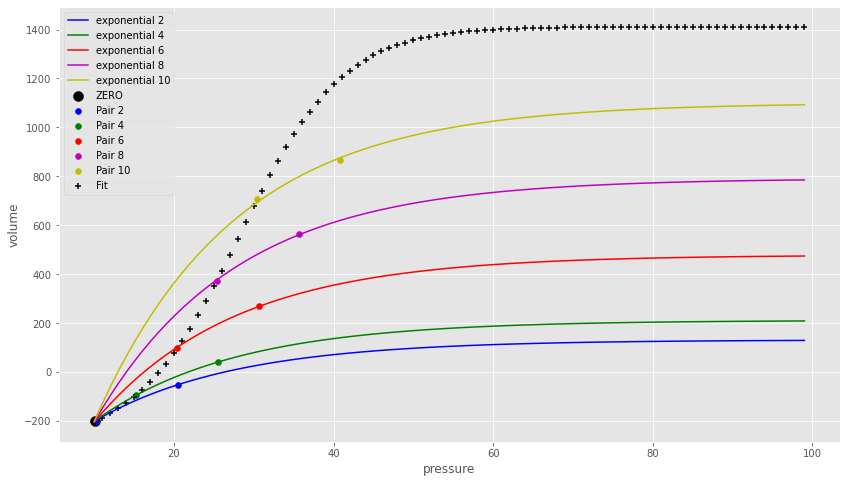

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


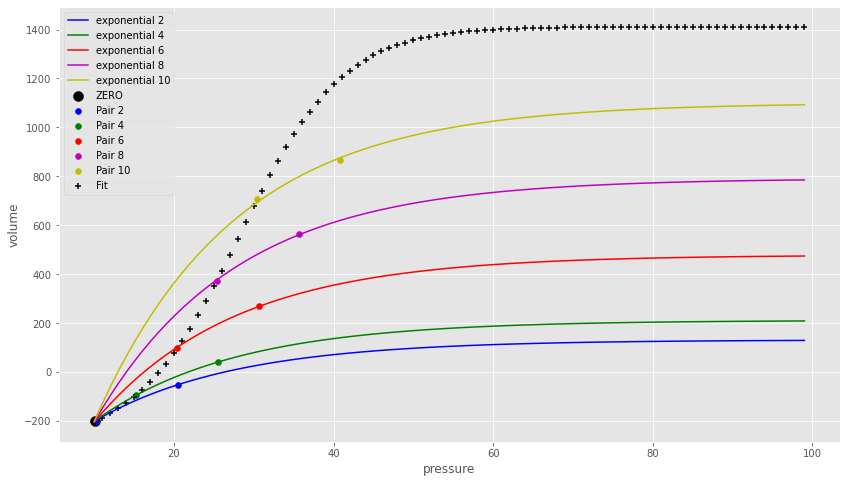

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247452]


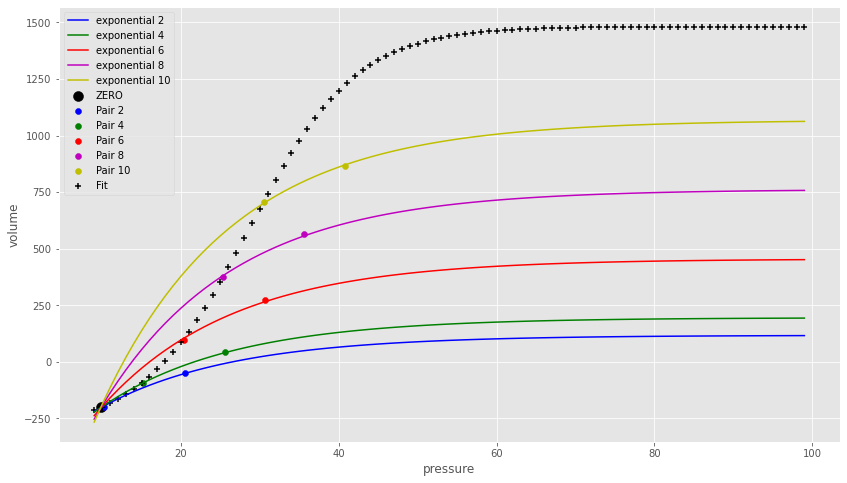

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247485]


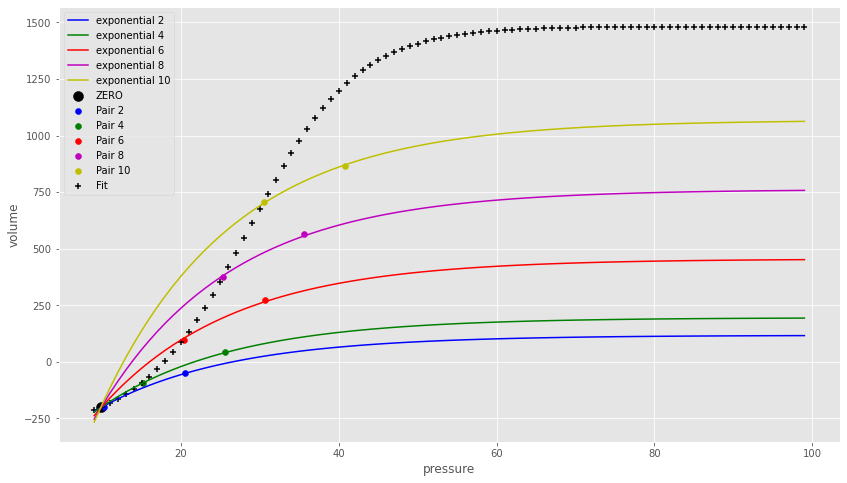

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247504]


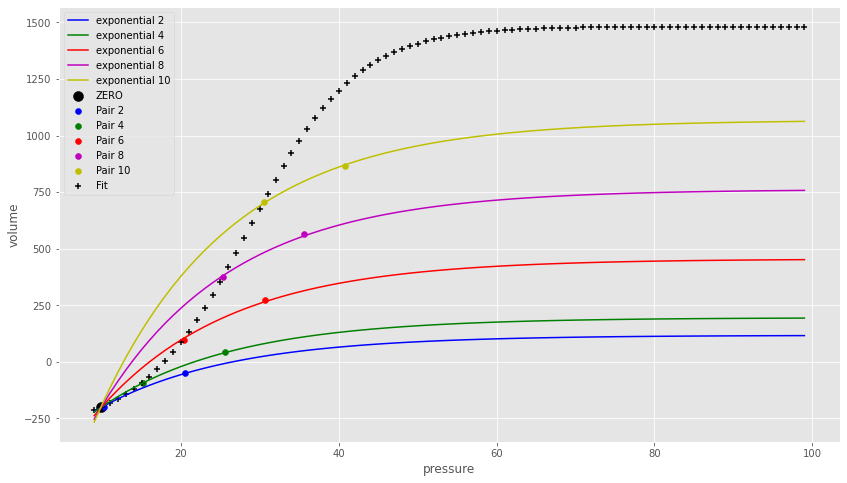

In [10]:
df_test["exponentials"] = df_test.apply(plot_exponentials, args = [exponential_cicle_fixed_b], axis=1)

In [25]:
df_test["exponentials"][0][0]

utils.exponential

In [28]:
aux = df_test["exponentials"][0][0]

In [14]:
def getMeanPoint(array, idx):
    pass
    
def test_frc_volume(ser):
    
    select_exp = 2
    
    [select_exp]
    guess_zero    = ser["guess_zero"]
    
    pressures = exponential.x
    exponential_volumes = exponential.y
    
    sigmoid_volumes   = ser["function"](pressures, *ser["param"])
    idx = np.argwhere(np.diff(np.sign(sigmoid_volumes - exponential_volumes))).flatten()
    
    plt.figure(figsize=(20,14))
    _=plt.plot(pressures, sigmoid_volumes, c = "r")
    _=plt.plot(pressures, exponential_volumes, c = "b")
    plt.scatter(pressures[idx], exponential_volumes[idx], c='k', s = 40)
    plt.scatter(raw_point[0], raw_point[1], c='g', s = 20)
    return idx

In [15]:
def test_frc_volume_2(ser):
    
    raw_data     = ser["raw_data"][::2]
    guess_zero   = ser["guess_zero"]
    exponentials = ser["exponentials"]
    colors = ["r","m","y","b","g","c"]
    plt.figure(figsize = (20,8))
    print(f"y-zero: {guess_zero[1]}")
    frc_lst = []
    vt_lst = []
    
    init_raw_x = raw_data[0][0]
    init_raw_y = raw_data[0][1]

    for idx, (color, (raw_x, raw_y)) in enumerate(zip(colors, raw_data)):
        
        exponential = exponentials[idx]
        plt.plot(exponential.x, exponential.y, c = color, label = f"exponential {idx}")

        frc = raw_y - guess_zero[1]
        frc_lst.append(frc)
        print(f"FRC = {frc} RAW_Y:{raw_y}")
        plt.vlines(x=raw_x, ymin=guess_zero[1], ymax=raw_y, lw = 1)
        
        
        
    sigmoid_volumes   = ser["function"](exponential.x, *ser["param"])
    plt.scatter(exponential.x, sigmoid_volumes, c = "black", marker = "+", label = "Sigmoid")

    plt.legend()
    plt.show()
    
    return frc_lst, vt_lst

y-zero: -199.4321542176138
FRC = 1.580423870934112 RAW_Y:-197.8517303466797
FRC = 104.29871610726224 RAW_Y:-95.13343811035156
FRC = 296.56742338265286 RAW_Y:97.13526916503906
FRC = 572.5086007508169 RAW_Y:373.0764465332031
FRC = 906.8288827332387 RAW_Y:707.396728515625


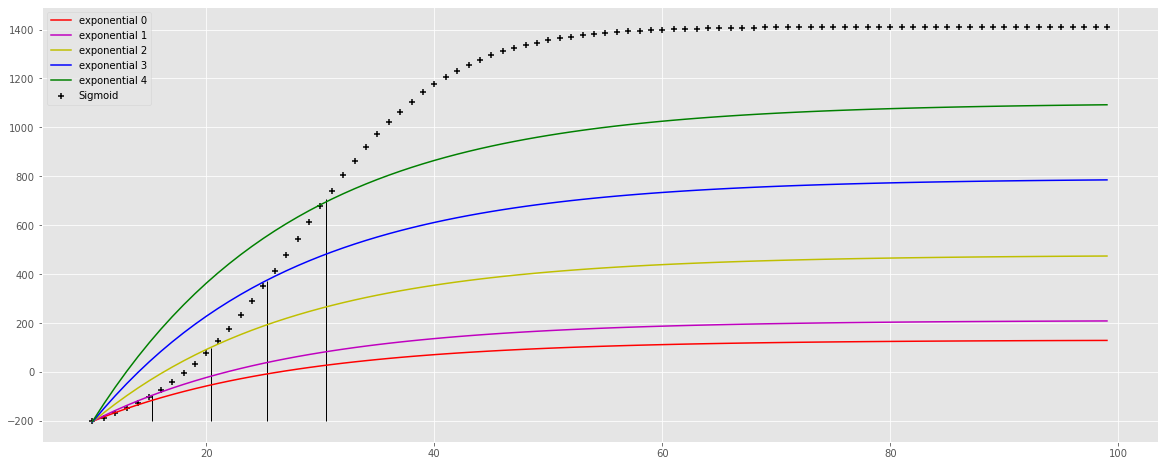

[1.580423870934112,
 104.29871610726224,
 296.56742338265286,
 572.5086007508169,
 906.8288827332387]

In [16]:
test_frc_volume_2(df_test.iloc[0,:])

y-zero: -199.4321542176138
FRC = 1.580423870934112 RAW_Y:-197.8517303466797
FRC = 104.29871610726224 RAW_Y:-95.13343811035156
FRC = 296.56742338265286 RAW_Y:97.13526916503906
FRC = 572.5086007508169 RAW_Y:373.0764465332031
FRC = 906.8288827332387 RAW_Y:707.396728515625


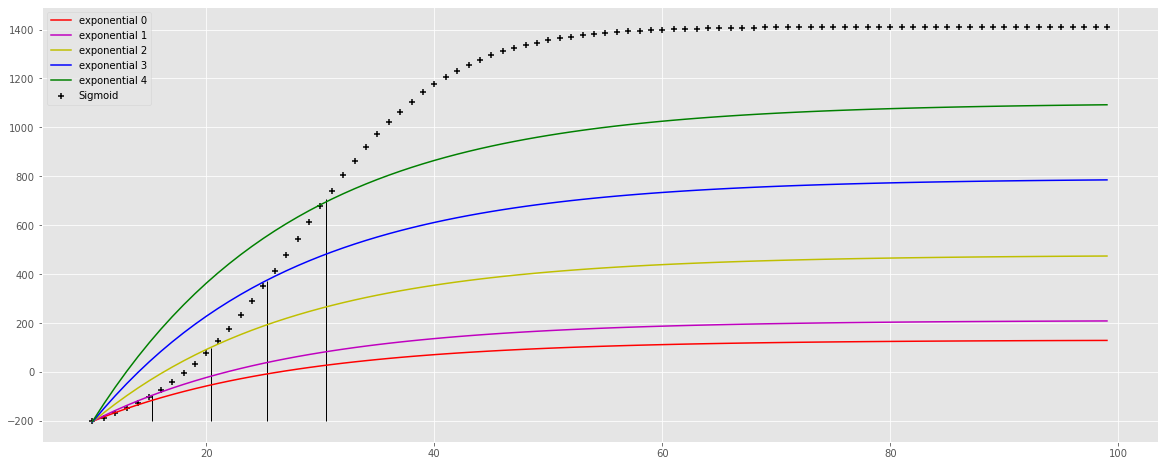

y-zero: -199.43215421796157
FRC = 1.58042387128188 RAW_Y:-197.8517303466797
FRC = 104.29871610761 RAW_Y:-95.13343811035156
FRC = 296.56742338300063 RAW_Y:97.13526916503906
FRC = 572.5086007511647 RAW_Y:373.0764465332031
FRC = 906.8288827335866 RAW_Y:707.396728515625


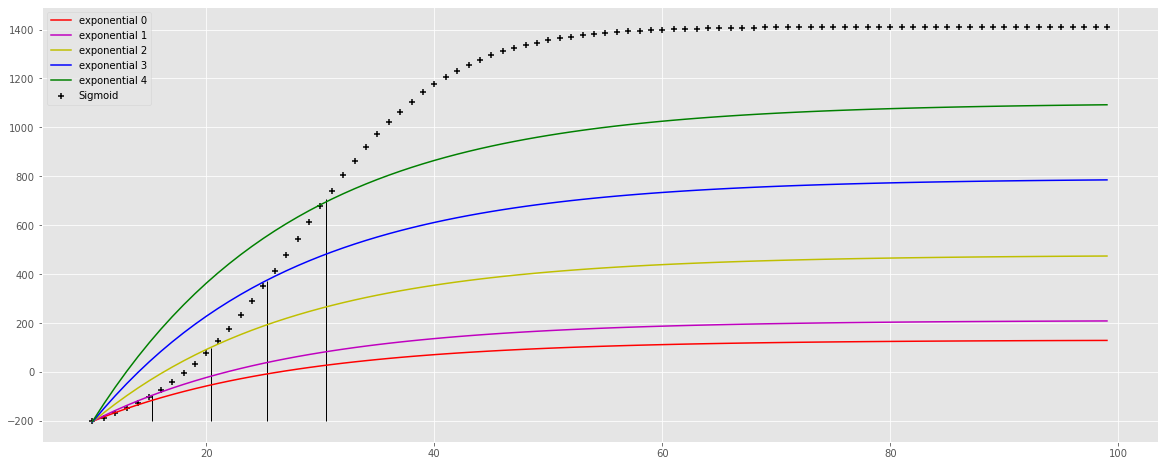

y-zero: -199.90247452282526
FRC = 2.050744176145571 RAW_Y:-197.8517303466797
FRC = 104.7690364124737 RAW_Y:-95.13343811035156
FRC = 297.03774368786435 RAW_Y:97.13526916503906
FRC = 572.9789210560284 RAW_Y:373.0764465332031
FRC = 907.2992030384503 RAW_Y:707.396728515625


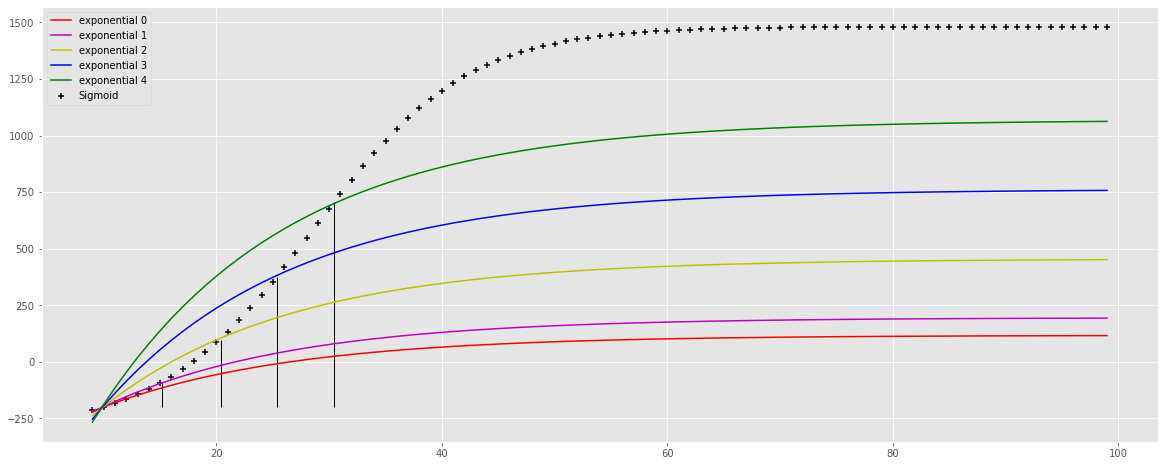

y-zero: -199.90247485018614
FRC = 2.0507445035064507 RAW_Y:-197.8517303466797
FRC = 104.76903673983458 RAW_Y:-95.13343811035156
FRC = 297.0377440152252 RAW_Y:97.13526916503906
FRC = 572.9789213833892 RAW_Y:373.0764465332031
FRC = 907.2992033658111 RAW_Y:707.396728515625


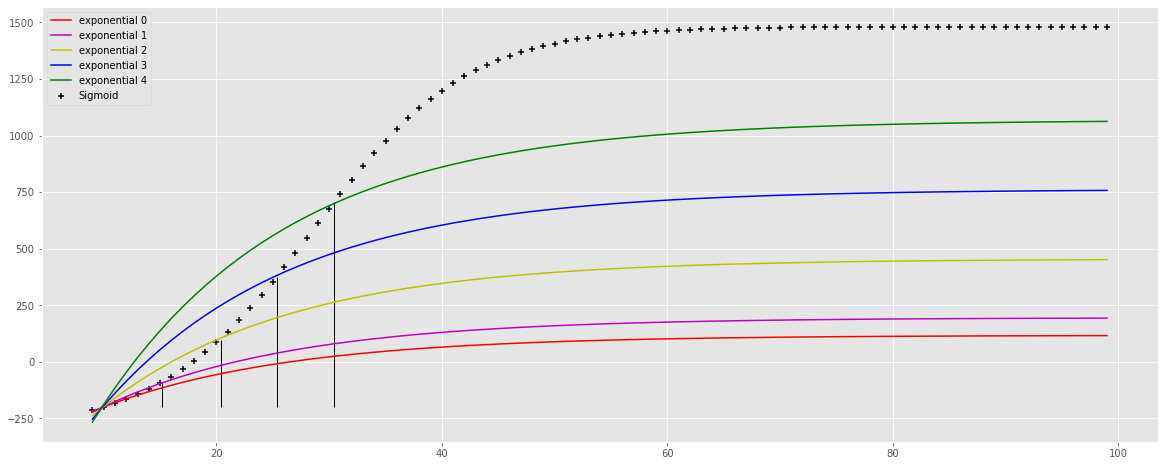

y-zero: -199.9024750407029
FRC = 2.050744694023223 RAW_Y:-197.8517303466797
FRC = 104.76903693035135 RAW_Y:-95.13343811035156
FRC = 297.037744205742 RAW_Y:97.13526916503906
FRC = 572.9789215739061 RAW_Y:373.0764465332031
FRC = 907.2992035563279 RAW_Y:707.396728515625


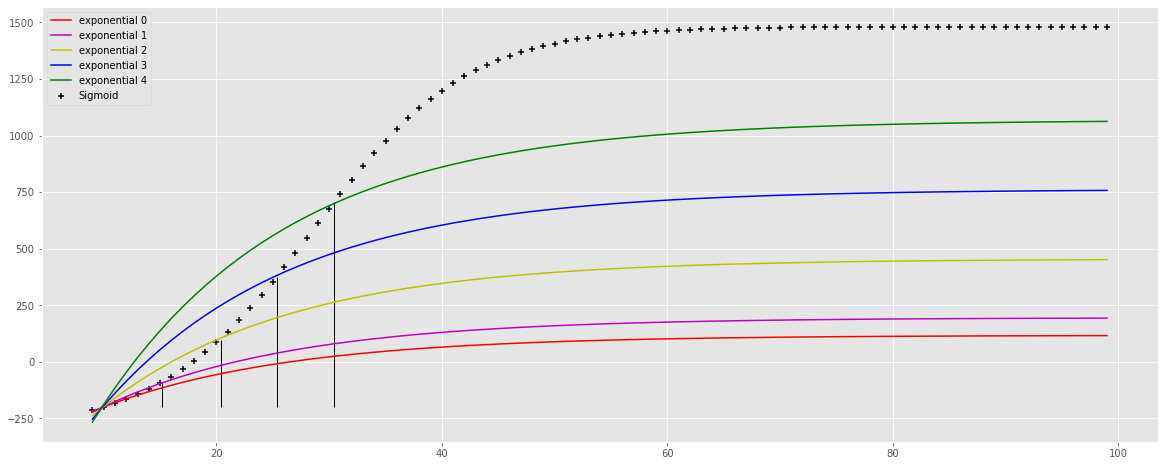

In [17]:
df_test["FRC_Volumes"] = df_test.apply(test_frc_volume_2,axis =1)